$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# CS236605:   Deep Learning
# Tutorial 3: Multilayer Perceptron

## Introduction

In this tutorial, we will cover:

* Linear (fully connected) layers
* Activation functions
* 2-Layer MLP implementation from scratch
* Back-propagation
* N-layer MLP with PyTorch's `autograd` and `optim` modules

In [1]:
# Setup
%matplotlib inline
import os
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20

## Reminder: The perceptron hypothesis class

The following hypothesis class
$$
\mathcal{H} =
\left\{ h: \mathcal{X}\rightarrow\mathcal{Y}
~\vert~
h(\vec{x}) = \varphi(\vectr{w}\vec{x}+b); \vec{w}\in\set{R}^D,~b\in\set{R}\right\}
$$
where $\varphi(\cdot)$ is some nonlinear function, is composed of functions representing the **perceptron** model.

Schematic of a single perceptron, and it's inspiration, a biological neuron.

| . | . |
|---|---|
| <img src="imgs/perceptron.png" width=400 /> | <img src="imgs/neuron.png" width=600 /> |

Last tutorial: we trained a **logistic regression** model by using
$$\varphi(\vec{z})=\sigma(\vec{z})=\frac{1}{1+\exp(-\vec{z})}\in[0,1].$$

**Limitation**: logistic regression is still a linear classifier. In what sense is it linear though?

$$\hat{y} = \sigma(\vectr{w}\vec{x}+b)$$

Generalized linear model: Output depends only on a linear combination of weights and inputs.

Decision boundaries are therefore straight lines:

<img src="imgs/perceptron_db.png"/>

## Multilayer Perceptron (MLP)

### Model

<img src="imgs/mlp.png" width=900 />

Composed of $L$ hidden **layers**, each layer $l$ with $n_l$ **perceptron** ("neuron") units.

Each layer $l$ operates on the output of the previous layer ($\vec{y}_{l-1}$) and calculates:
$$
\vec{y}_l = \varphi\left( \mat{W}_l \vec{y}_{l-1} + \vec{b}_l \right),~
\mat{W}_l\in\set{R}^{n_{l}\times n_{l-1}},~ \vec{b}_l\in\set{R}^{n_l}.
$$

- Note that both input and output are **vectors**. We can think of the above equation as describing a layer of **multiple perceptrons**.
- We'll henceforth refer to such layers as **fully-connected** or FC layers.
- The first layer accepts the input of the model, i.e. $\vec{y}_0=\vec{x}\in\set{R}^d$.

Given an input sample $\vec{x}^i$, the computed function of an $L$-layer MLP is:
$$
\vec{y}_L^i= \varphi \left(
\mat{W}_L \varphi \left( \cdots
\varphi \left( \mat{W}_1 \vec{x}^i + \vec{b}_1 \right)
\cdots \right)
+ \vec{b}_L \right)
$$

- Universal approximator theorem: an MLP with $L>1$, can approximate (almost) any function given enough parameters (Cybenko, 1989).
- This expression is fully differentiable w.r.t. parameters using the Chain Rule.

Given an input sample $\vec{x}^i$, the computed function of an $L$-layer MLP is:
$$
\vec{y}_L^i= \varphi \left(
\mat{W}_L \varphi \left( \cdots
\varphi \left( \mat{W}_1 \vec{x}^i + \vec{b}_1 \right)
\cdots \right)
+ \vec{b}_L \right)
$$

- Universal approximator theorem: an MLP with $L>1$, can approximate (almost) any function given enough parameters (Cybenko, 1989).
- This expression is fully differentiable w.r.t. parameters using the Chain Rule.

- Since it has a non-linear dependency on it's weights and inputs, non-linear decision boundaries are possible
    - MLP with 1, 2 and 4 hidden layers, 3 neurons each
    
    <img src="imgs/overfit_1-2-4HL_3N.jpg" width="700" alt="overfit1">

### Activation functions 

An **activation function** is the non-linear elementwise function $\varphi(\cdot)$ which operates on the affine part of the perceptron model.

But why do we even need non-linearities?

Without them, the MLP model would be equivalent to a single affine transform.

Common choices for the activation functions are:

- The logistic function (sigmoid)
    $$ \varphi(t) = \sigma(t) = \frac{1}{1+e^{-t}} \in  [0,1] $$
- The hyperbolic tangent (a shifted and scaled sigmoid)
    $$ \varphi(t) = \mathrm{tanh}(t) = \frac{e^t - e^{-t}}{e^t +e^{-t}} \in [-1,1]$$

- ReLU, rectified linear unit
    $$ \varphi(t) = \max\{t,0\} $$
Note that
    $$ \pderiv{\varphi}{t} = \begin{cases} 1, & t>0 \\ 0, & t<0 \end{cases} $$

In [2]:
# Plot some activation functions and their gradients
# Activation functions
relu = lambda x: np.maximum(0, x)
sigmoid = lambda x: 1 / (1 + np.exp(-x))
tanh = lambda x: (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))
# Their gradients
g_relu = lambda x: np.array(relu(x) > 0, dtype=np.float)
g_sigmoid = lambda x: sigmoid(x) * (1-sigmoid(x))
g_tanh = lambda x: (1 - tanh(x) ** 2)

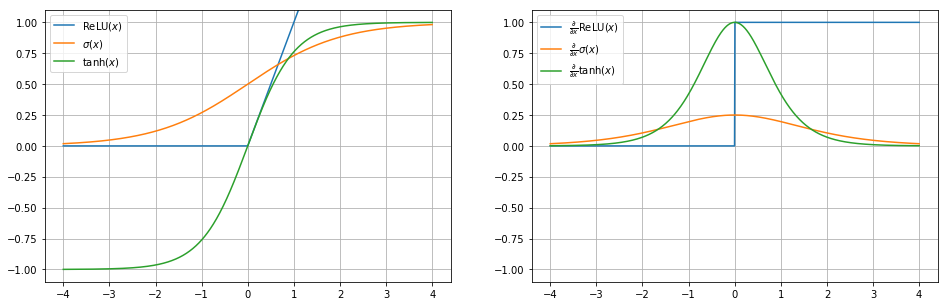

In [3]:
x = np.linspace(-4, 4, num=1024)
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
axes[0].plot(x, relu(x), x, sigmoid(x), x, tanh(x))
axes[1].plot(x, g_relu(x), x, g_sigmoid(x), x, g_tanh(x))
legend_entries = (r'\mathrm{ReLU}(x)', r'\sigma(x)', r'\mathrm{tanh}(x)')
for ax, legend_prefix in zip(axes, ('', r'\frac{\partial}{\partial x}')):
    ax.grid(True)
    ax.legend(tuple(f'${legend_prefix}{legend_entry}$' for legend_entry in legend_entries))
    ax.set_ylim((-1.1,1.1))

Some reasons for using ReLU are:

- Mitigates vanishing gradients due to many layers (even though they can still be zero).
- Promotes sparse weight vectors: "dead neurons" arguably cause sparsity in the next layer.
- Much faster to compute than sigmoid and tanh.

## 2-Layer MLP from scratch

Let's solve a simple **regression** problem with a 2-layer MLP (one hidden layer, one output layer).

We're trying to learn a continuous and perhaps non-deterministic function $y=f(\vec{x})$.

- Domain: $\vec{x}^i \in \set{R}^{D_{\text{in}}}$
- Target: $y^i \in \set{R}^{D_{\text{out}}}$
- Model: $\hat{y} = \varphi(\mat{X}\mat{W}_1 + \vec{b}_1)\mat{W}_2 + \vec{b}_2$ (2-layer MLP), where:
    - $\mat{X}$ is the $(N,D_{\text{in}})$ matrix with samples in it's rows
    - $\mat{W}_1\in\set{R}^{D_{\text{in}}\times H},\ \vec{b}_1\in\set{R}^{H}$
    - $\mat{W}_2\in\set{R}^{H\times D_{\text{out}}},\ \vec{b}_2\in\set{R}^{D_{\text{out}}}$
    - $\varphi(\cdot) = \mathrm{ReLU}(\cdot) = \max\{\cdot,0\}$
    - $H$ is the hidden dimension
    - We'll set $D_{\text{out}}=1$ so output is a vector
- MSE loss with L2 regularization:
    $$
    L_{\mathcal{D}}(h) =
    \frac{1}{N}\norm{\hat{\vec{y}} - \vec{y}}_2^2 + \frac{\lambda}{2}\left(\norm{\mat{W}_1}_F^2 + \norm{\mat{W}_2}_F^2 \right)
    $$
- Optimization scheme: Vanilla SGD

### Computing the loss gradients with backpropagation

Ignoring regularization, we define for brevity, $\delta X \triangleq \pderiv{L(h)}{X}$.

We can now apply the chain rule and write
$$
\begin{align}
\delta \hat{\vec{y}} &= \pderiv{L}{\hat{\vec{y}}} = \frac{2}{N}\left(\hat{\vec{y}} - \vec{y}\right) \\
\delta \mat{W}_2 &= \delta\hat{\vec{y}} \pderiv{\hat{\vec{y}}}{\mat{W}_2}  = \mattr{A}_b \delta\hat{\vec{y}}\\
\delta\mat{A}_b &= \delta\hat{\vec{y}} \pderiv{\hat{\vec{y}}}{\mat{A}_b} = \delta\hat{\vec{y}} \mattr{W}_2 \\
\delta\mat{Z} &= \delta\mat{A}\pderiv{\mat{A}}{\mat{Z}} = \delta\mat{A}\odot\mathbb{1}(\mat{Z}>0) \\
\delta\mat{W}_1 &= \delta\mat{Z}\pderiv{\mat{Z}}{\mat{W}_1} = \mattr{X}_b \delta\mat{Z}
\end{align}
$$

The final gradients for weight update, including regularization will be $\delta\mat{W}_i + \lambda\mat{W}_i$.

In [4]:
# A simple MLP with one hidden layer

# N: batch size
# D_in: number of features
N, D_in =  64, 10
# H: hidden-layer
# D_out: output dimension
H, D_out =  100, 1

# Random input data
X = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Model weights (note: bias included)
W1 = np.random.randn(D_in+1, H)
W2 = np.random.randn(H+1, D_out)

reg_lambda = 0.5
learning_rate = 1e-3

In [5]:
losses = []
for epoch in range(250):
    # Forward pass, hidden layer: A = relu(Xb W1), Shape: (N, H+1)
    Xb = np.hstack((np.ones((N,1)), X))
    Z = Xb.dot(W1)
    A = np.maximum(Z, 0)
    # Forward pass, output layer: Y_hat = A W2, Shape: (N, D_out)
    Ab = np.hstack((np.ones((N,1)), A))
    Y_hat = Ab.dot(W2)
    
    # Loss calculation (MSE)
    loss = np.mean((Y_hat - y) ** 2); losses.append(loss)
    
    # Backward pass:  Output layer
    d_Y_hat = (2./N) * (Y_hat - y)
    d_W2 = Ab.transpose().dot(d_Y_hat)
    d_Ab = d_Y_hat.dot(W2.transpose())
    # Backward pass: Hidden layer
    d_A = d_Ab[:,1:] # remove bias col
    d_Z = d_A * np.array(Z > 0, dtype=np.float)
    d_W1 = Xb.transpose().dot(d_Z)
    # Backward pass: Regularization term
    d_W2 += reg_lambda * W2
    d_W1 += reg_lambda * W1
    
    # Gradient descent step
    W2 -= d_W2 * learning_rate
    W1 -= d_W1 * learning_rate
    
    print('.', end='')

..........................................................................................................................................................................................................................................................

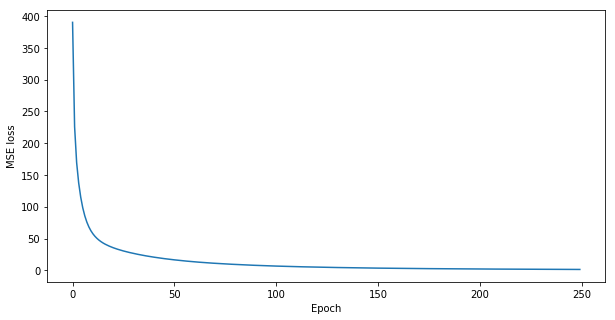

In [6]:
_, ax = plt.subplots(figsize=(10,5))
ax.plot(losses)
ax.set_ylabel('MSE loss'); ax.set_xlabel('Epoch');

Note that this implementation is not ideal, as it's:

- Non modular (hard to switch components)
- Hard to extend (e.g. to add layers)
- Error prone (hard-coded manual calculations)

But it works!
- In HW2, you'll implement a from scratch MLP that addresses these concerns.
- And now, we'll see how to address these issues using PyTorch's API.

## N-Layer MLP using PyTorch

Let's create all our usual components:
- Dataset
- Model
- Loss function
- Optimizer

But this time we'll create a modular implementation where each of these components is separate and can be changed independently of the others.

### Dataset

As in the previous tutorial we'll tackle an image classification task, the MNIST database of handwritten digits.

In [7]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as tvtf

# Define the transforms that should be applied to each image in the dataset before returning it
tf_ds = tvtf.Compose([
    tvtf.ToTensor(), # Convert PIL image to pytorch Tensor
    tvtf.Normalize(mean=(0.1307,), std=(0.3081,)) # normalize to zero mean and unit std
])

batch_size = 512
train_size = batch_size * 10
test_size = batch_size * 2

# Datasets and loaders
root_dir = os.path.expanduser('~/.pytorch-datasets/mnist/')
ds_train = torchvision.datasets.MNIST(root=root_dir, download=True, train=True, transform=tf_ds)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size,
                                       sampler=torch.utils.data.SubsetRandomSampler(range(0,train_size)))
ds_test =  torchvision.datasets.MNIST(root=root_dir, download=True, train=False, transform=tf_ds)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size,
                                       sampler=torch.utils.data.SubsetRandomSampler(range(0,test_size)))

x0, y0 = ds_train[0]
n_features = torch.numel(x0)
n_classes = 10

print(f'x0: {x0.shape}, y0: {y0}')

x0: torch.Size([1, 28, 28]), y0: 5


### Model Implementation

- The `torch.nn` module contains building blocks such as neural network layers,
  loss functions, activations and more.

- We'll implement our model as a subclass of `nn.Module`, which means:
    - Any tensors we set as properties will be registered as model parameters.
    - We can nest `nn.Modules` and get all model parameters from the top-level `nn.Module`.
    - Can be used as a function if we implement the `forward()` method.

In [8]:
import torch.nn as nn

class MLP(torch.nn.Module):
    def __init__(self, D_in: int, hidden_dims: list, D_out: int):
        super().__init__()
        
        all_dims = [D_in, *hidden_dims, D_out]
        layers = []
        
        for in_dim, out_dim in zip(all_dims[:-1], all_dims[1:]):
            layers += [
                nn.Linear(in_dim, out_dim, bias=True),
                nn.ReLU()
            ]
        
        self.fc = nn.Sequential(*layers)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], -1))
        z = self.fc(x)
        y_pred = self.log_softmax(z)
        return y_pred

In [9]:
# Create an instance of the model (5-layer MLP)
mlp5 = MLP(D_in=n_features, hidden_dims=[32, 64, 128, 64], D_out=n_classes)
print(mlp5)

MLP(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=10, bias=True)
    (9): ReLU()
  )
  (log_softmax): LogSoftmax()
)


In [10]:
print(f'number of parameter tensors: {len(list(mlp5.parameters()))}')

number of parameter tensors: 10


In [11]:
print(f'number of parameters: {np.sum([torch.numel(p) for p in mlp5.parameters()])}')

number of parameters: 44458


In [12]:
# Test a forward pass
y_hat0 = mlp5(x0)

print(f'y_hat0={y_hat0},\nshape={y_hat0.shape}')

y_hat0=tensor([[-2.3167, -2.3167, -2.2767, -2.2198, -2.3167, -2.3167, -2.3167, -2.3167,
         -2.3167, -2.3167]], grad_fn=<LogSoftmaxBackward>),
shape=torch.Size([1, 10])


### Loss and Optimizer

- For the loss, we'll use PyTorch's built in cross-entropy loss.
- We won't need to calculate the loss gradient this time, as we'll use `autograd` for automatic differentiation.
- As for the optimization scheme, we'll use a built in SGD optimizer from the `torch.optim` module.

In [13]:
import torch.optim

# Model
model = MLP(D_in=n_features, hidden_dims=[32, 32, 32], D_out=n_classes)

# Loss:
# Note: NLLLoss assumes log-probabilities (given by our LogSoftmax layer)
loss_fn = nn.NLLLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-2, weight_decay=0.1, momentum=0.9)

### Training loop

This time we'll train over lazy-loaded batches from our data loader.

Notice that except from our model's `__init__()` and `__forward()__`, we're using PyTorch facilities for the entire training implementation.

In [14]:
num_epochs = 10
for epoch_idx in range(num_epochs):
    total_loss = 0
    for batch_idx, (X, y) in enumerate(dl_train):
        # Forward pass
        y_pred = model(X)

        # Compute loss
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad() # Zero gradients of all parameters
        loss.backward()
        
        # Weight update
        optimizer.step()
        
    print(f'Epoch #{epoch_idx+1}: Avg. loss={total_loss/len(dl_train)}')

Epoch #1: Avg. loss=2.3054928541183473
Epoch #2: Avg. loss=2.3014203310012817
Epoch #3: Avg. loss=2.2982772827148437
Epoch #4: Avg. loss=2.2965104579925537
Epoch #5: Avg. loss=2.2955925703048705
Epoch #6: Avg. loss=2.2952797651290893
Epoch #7: Avg. loss=2.2953588247299193
Epoch #8: Avg. loss=2.2957545042037966
Epoch #9: Avg. loss=2.29633150100708
Epoch #10: Avg. loss=2.296979832649231


## Image credits
- MartinThoma [CC0], via Wikimedia Commons https://commons.wikimedia.org/wiki/File:Perceptron-unit.svg
- Sebastian Raschka https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html
- Favio Vázquez https://towardsdatascience.com/a-conversation-about-deep-learning-9a915983107
- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017